# Eating and drinking found to be useful in prediction of religious activity

Kian Baula (qdb94),
Christian Duvarney (cpd498),
Christopher Frazier (clf2328),
Negin Raoof (nm24745)

## Introduction
There have been studies such as [1] that try to analyze the differences in religious and nonreligious people’s behavior and activities. Some may believe that religious people may tend to have lower educational level, or they tend to spend more time doing volunteer social care activities. Our goal for our final project is to determine whether certain assumptions regarding both religious and nonreligious people are true. Furthermore, we will look for other correlations with religiousness in aspects such as mental and physical health, familial interaction, social consciousness, to name a few. Lastly, we will investigate whether other factors such as socioeconomic status, demographic, or geographic location also play a role in these trends. In general, we aim to specify which activities play a more important role in predicting religiousness among different groups.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import RandomizedSearchCV, train_test_split,cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier, LinearRegression
from IPython.display import Image
%matplotlib inline

## About our Dataset
# [KIAN stuff]
There have been studies trying to analyze the differences in religious and nonreligious people’s behavior and activities.  Some may believe that religious and non-religious people may have received different levels of education on average, or some may beluieve that religous and non-religious people spend significantly different amounts of time doing volunteer social care activities. So, we wanted to determine to what extent are such assumptions true. Furthermore, we wanted to specify whether daily activities of an individual are statistically important in predicting religiousness among different groups.

In [14]:
resp_df = pd.read_csv('atusresp.csv')
actions_df = pd.read_csv('atusact.csv')
roster = pd.read_csv('atusrost.csv')[['tucaseid', 'teage', 'tesex']]

In [3]:
# All columns in the respondant dataset
action_all_cols = ['tucaseid', 'tuactivity_n', 'tuactdur24', 'tucc5', 'tucc5b',
        'trtcctot_ln', 'trtcc_ln', 'trtcoc_ln', 'tustarttim', 'tustoptime',
        'trcodep', 'trtier1p', 'trtier2p', 'tucc8', 'tucumdur',
        'tucumdur24', 'tuactdur', 'tr_03cc57', 'trto_ln', 'trtonhh_ln',
        'trtohh_ln', 'trthh_ln', 'trtnohh_ln', 'tewhere', 'tucc7',
        'trwbelig', # is activity eligable for well-being module
        'trtec_ln', 'tuec24', 'tudurstop']
action_trash_cols = [
    'tuactivity_n', # activity no. reported
    'tucumdur', # cumulative total of tuactdur
    'tucumdur24', # cumulative total of tuactdur24
    'tr_03cc57', # tucc5 OR tucc5b
    'tuec24', # which times or which activities did you provide care in trtec_ln (missing < 2011)
    'tudurstop' # method for reporting activity duration (missing < 2012)
]
action_maybe_trash_cols = [
    'tucc5', # was a household child in your care
    'tucc5b', # was a non-household child in your care
    'trtcctot_ln', # time spent providing household child care during activity
    'trtcc_ln', # time spent providng secondary childcare for children < 13 yr/age
    'trtcoc_ln', # time spent providing non-houselind child care during activity
    'tustarttim', # start time of activity
    'tustoptime', # end time of activity
    'tucc8', # was there a child (not yours) in your care during activity
    'trto_ln', # total time spend during activity providng secondary child care for household children
    'trtonhh_ln', # total time spend during activity providng secondary child care for non-household children
    'trtohh_ln', # total time spent taking care of own household child
    'trthh_ln', # total time spent taking care of household child
    'trtnohh_ln', # total time spent taking care of non-household child 
    'tucc7', # was a own non-household child in your care
    'trtec_ln' # time spent providing eldercare
]
action_use_cols = list(set(action_all_cols) - set(action_trash_cols + action_maybe_trash_cols))

A breakdown of activities by counts:

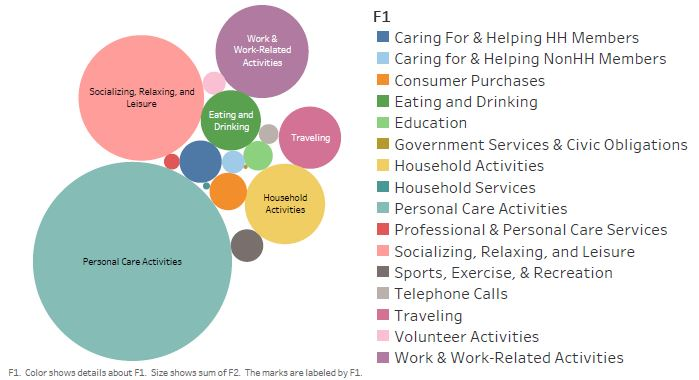

In [18]:
Image("american-time-use-surveycapture.jpg")

The table below represents how much time do men and women of differen ages spend doing religious activities.

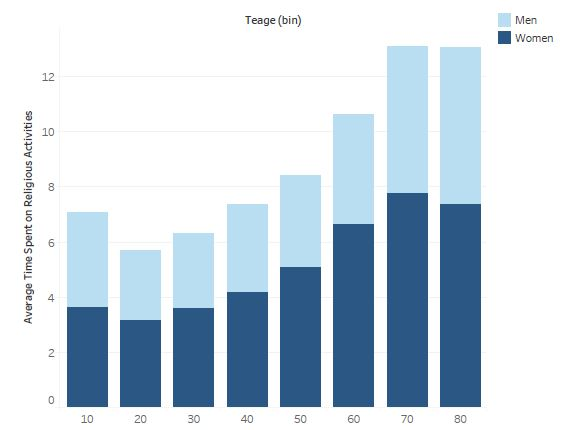

In [28]:
Image("Capture4.JPG")

Overall, there is an increasing trend in spending time on religious activities as people get older. Also women are more tended to spend time on such activities.

For example, the figure below shows the total hours that men and women spent time watching religious and non-religious TV programs.

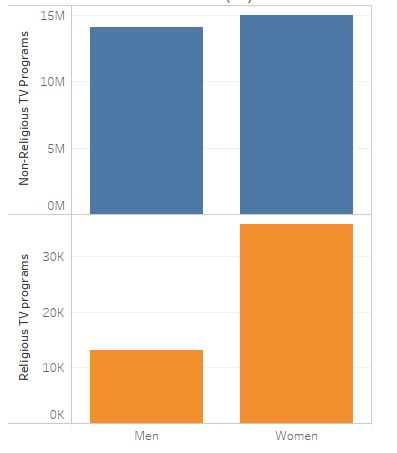

In [19]:
Image("genderDist.jpg")

We can see that women spend much more time watching religious TV programs compared to men.
$$ $$
We can also see how people of different ages spend their time watching religious and non-religious TV programs.

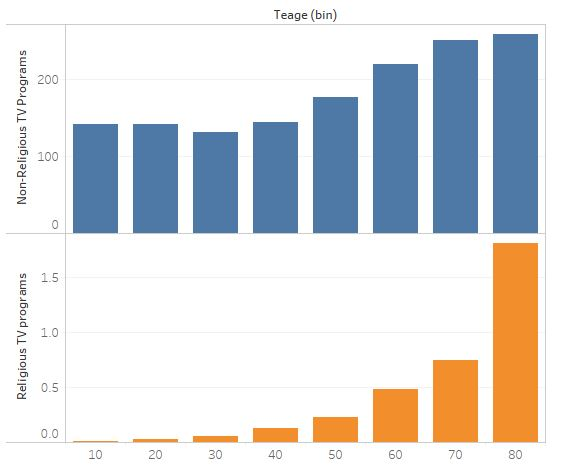

In [20]:
Image("ageTVDist.jpg")

It is clear from the graph that as people get older, they spend more time watching religious programs on TV.

Formatting our dataset and filling in nan's...

In [ ]:
religious_activity_df = actions_df[actions_df['trtier1p'] == 14][['tucaseid','tuactdur']].groupby('tucaseid').sum()
religious_activity_df['tuactdur'] = religious_activity_df.shape[0] * [1]
resp_activity_df = resp_df.join(religious_activity_df, on='tucaseid')
resp_activity_df['tuactdur'].fillna(0, inplace=True)

In [5]:
X = resp_activity_df.drop('tuactdur', axis=1).select_dtypes(exclude=[object])
y = resp_activity_df['tuactdur']

### How we chose our cost function
We chose the AUC score because of the class skew as demonstrated below

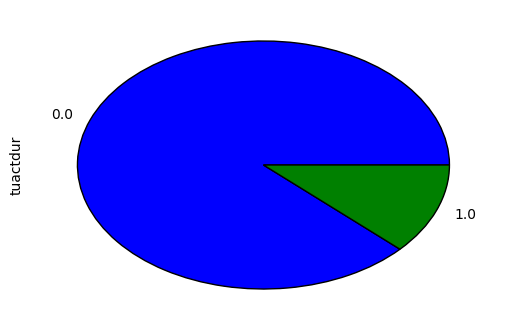

In [15]:
resp_activity_df['tuactdur'].value_counts().plot.pie()

## The Approach and Story
Because this is not a competition and we do not have the results of anyone else on this topic, we began by forming a baseline for our performance throughout our experimentation. The baseline decided on was an XGBoost classifier on the plain attributes of the survey taker (household size, age, etc.).

### Baseline result with just respondant data using XGBoost: 0.69372230422679892


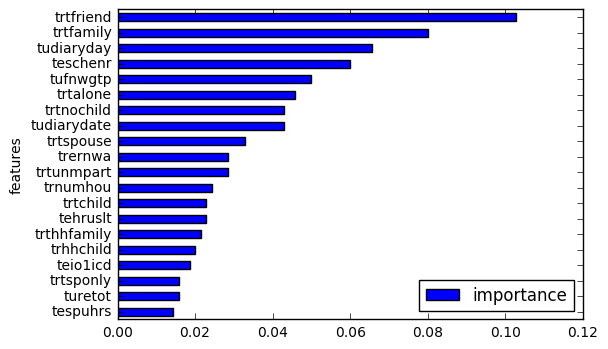

In [6]:
gbc_full_base = XGBClassifier(nthread=-1).fit(X,y)
features = X.columns.values
feature_importance = gbc_full_base.feature_importances_

feature_importance_df = pd.DataFrame({'features':features, 'importance':feature_importance})\
    .sort_values('importance',ascending=False)
feature_importance_df[:20].sort_values('importance',ascending=True).plot.barh(x='features',y='importance')

### Watching out for unwanted dependencies in data
Our first step from this baseline was adding in the other activities of the survey taker (any non-religious activities). This required us to take caution for potential dependencies within the data not simply attributed to activity correlation. 
There were three main forms of bias we attempted to address. 

In [21]:
featImport = pd.Series(xgb.feature_importances_, index=Xplusplus[importantCols].columns)
featImport = featImport.rename(columnNames)
featImport.sort(ascending=False)
featImport.to_frame()

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  app.launch_new_instance()


,0
Eating and Drinking,0.171429
Traveling,0.141991
Personal Care Activities,0.125758
Consumer Purchases,0.091558
"Socializing, Relaxing, and Leisure",0.073593
Household Activities,0.069913
Work & Work-Related Activities,0.046753
"Sports, Exercise, & Recreation",0.045238
Telephone Calls,0.044372
Caring for & Helping NonHH Members,0.038528


In [8]:
columnNames = {1: "Personal Care Activities",
2: "Household Activities",
3: "Caring For & Helping HH Members",
4: "Caring for & Helping NonHH Members",
5: "Work & Work-Related Activities",
6: "Education",
7: "Consumer Purchases",
8: "Professional & Personal Care Services",
9: "Household Services",
10: "Government Services & Civic Obligations",
11: "Eating and Drinking",
12: "Socializing, Relaxing, and Leisure",
13: "Sports, Exercise, & Recreation" ,
14: "Religious and Spiritual Activities" ,
15: "Volunteer Activities" ,
16: "Telephone Calls",
18: "Traveling",
50: "Data Codes"}
Xplusplus = Xplusplus.rename(columns=columnNames)
importantCols = ["Personal Care Activities",
"Household Activities",
"Caring For & Helping HH Members",
"Caring for & Helping NonHH Members",
"Work & Work-Related Activities",
 "Education",
"Consumer Purchases",
"Professional & Personal Care Services",
"Household Services",
"Government Services & Civic Obligations",
"Eating and Drinking",
"Socializing, Relaxing, and Leisure",
"Sports, Exercise, & Recreation" ,
"Volunteer Activities" ,
"Telephone Calls",
"Traveling",
"Data Codes"] 
xgb = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=4, missing=None, n_estimators=700, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)
X_train, X_test, y_train, y_test = train_test_split(Xplusplus[importantCols], y, test_size=.3, random_state=12)
xgb.fit(X_train,y_train)
print(roc_auc_score(y_test, [x[1] for x in xgb.predict_proba(X_test)]))

0.856847450153


### First form of dependency
For instance we found survey takers would answer with a mean of 19.5 activities with a variance of 8, hinting that users may oversimplify their actual activities and only report a certain number. For example, if we know there are currently 30 activities listed, the likelihood that another would be listed (a religious one) is very unlikely given the normal distribution.
<Activity Count Graph>

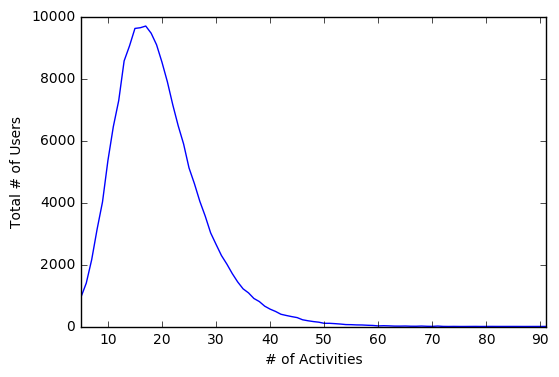

In [13]:
ax = actions_df[['tucaseid', 'tuactivity_n']]\
    .groupby(by='tucaseid')['tuactivity_n'].max().value_counts().sort_index().plot()
ax.set_xlabel("# of Activities")
ax.set_ylabel("Total # of Users")

Testing this with all used models, we found that the benefit is only marginal, and some benefit can even be attributed unrelated to the bias. It is difficult to distinguish what is from the bias of user simplification and what is a valid correlation between number of activities and our hypothesis. We also tested the predictive value of tuactivity_n by itself and found that it acheived an AUC score of ~.6 in both models we utilized which we felt was small enough as to not introduce too large of a bias.

### Second form of dependency
Another concern was a similar idea, but instead of activity count, the bias caused by total time a user spent on activities (since this could also relate to oversimplified reported activities).
This issue was solved simply removing the total time and in part by the steps taken to solve our thrid form of dependency.

### Third form of dependency
Finally, the largest dependency was the requirement of total time to be within 21-24 hours. For example, this means that if the total time is at 20 hours and 30 minutes the model could accurately deduce that, because a religious activity is the only activity not know and we know there must be another activity from what is known (to complete the required 21-24 hour range.
This was address by removing total time and changing the features of each activity from time to a percentage of remaining time space (making deduction of total time spent difficult to estimate).

#### Add in our low bias model and two features for age and gender

In [7]:
def sexCategory(x):
    if x<1.5:
        return 0
    if x>1.5:
        return 1
    else:
        return 2

rostFeatures = roster.groupby('tucaseid').aggregate(np.mean)
rostFeatures['tesex'] = rostFeatures['tesex'].apply(sexCategory)
rostFeatures = rostFeatures.reset_index()
Xplus = X.merge(rostFeatures, on='tucaseid')
Xplus = Xplus.drop(['temjot', 'trdpftpt'], axis=1)
gbc_base = XGBClassifier(nthread=-1)
score = cross_val_score(gbc_base, Xplus, y, scoring='roc_auc', verbose=0, n_jobs=1).mean()
print(score)
grouped =actions_df[['tucaseid','trtier1p', 'tuactdur']].groupby(['tucaseid','trtier1p']).aggregate(np.sum)
actTimes = grouped.reset_index().pivot(index='tucaseid', columns='trtier1p', values='tuactdur').fillna(0)
actTimes= actTimes.reset_index()
Xplusplus = Xplus.merge(actTimes, on='tucaseid').drop(14, axis=1)

0.707832164974


In [10]:
numAct = actions_df[['tucaseid', 'tuactivity_n']].groupby(by='tucaseid')['tuactivity_n'].max().to_frame().reset_index()
Xplusplus = Xplusplus.merge(numAct, on='tucaseid')
newX = Xplusplus[importantCols]
newX['sum'] = newX.sum(axis=1)
for col in importantCols:
    newX[col] = newX[col]/ newX['sum']
scaledX = pd.DataFrame(StandardScaler().fit_transform(newX), columns=newX.columns)
X_train, X_test, y_train, y_test = train_test_split(scaledX[importantCols], y, test_size=.3, random_state=12)
logReg = LogisticRegressionCV(Cs=20, fit_intercept=True, cv=None,
                              dual=False, penalty='l1', scoring='roc_auc', 
                              solver='liblinear', tol=0.0001, max_iter=1000, 
                              class_weight=None, n_jobs=-1, verbose=0, 
                              refit=True, intercept_scaling=1.0, 
                              multi_class='ovr', random_state=None)
logReg.fit(X_train,y_train)
print(roc_auc_score(y_test, [x[1] for x in logReg.predict_proba(X_test)]))

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.699633539279


In [11]:
feat = pd.Series(logReg.coef_[0], index=importantCols)
feat.sort(ascending=False)
feat.to_frame()

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  from ipykernel import kernelapp as app


,0
Personal Care Activities,0.391082
Traveling,0.214759
Eating and Drinking,0.194385
Volunteer Activities,0.157419
Telephone Calls,0.099639
"Socializing, Relaxing, and Leisure",0.058593
Data Codes,0.051125
Caring For & Helping HH Members,0.000000
Household Activities,0.000000
Government Services & Civic Obligations,-0.013536


In [12]:
xgb = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=4, missing=None, n_estimators=700, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)
X_train, X_test, y_train, y_test = train_test_split(newX[importantCols], y, test_size=.3, random_state=12)
xgb.fit(X_train,y_train)
print(roc_auc_score(y_test, [x[1] for x in xgb.predict_proba(X_test)]))
featImport = pd.Series(xgb.feature_importances_, index=importantCols)
featImport.sort_values(ascending=False, inplace=True)
featImport.to_frame()

0.819124293842


,0
Eating and Drinking,0.171429
Traveling,0.141991
Personal Care Activities,0.125758
Consumer Purchases,0.091558
"Socializing, Relaxing, and Leisure",0.073593
Household Activities,0.069913
Work & Work-Related Activities,0.046753
"Sports, Exercise, & Recreation",0.045238
Telephone Calls,0.044372
Caring for & Helping NonHH Members,0.038528


## Results
The logistic regression coefficiencts in combination with XGBoost feature importance indicated that the most informative faetures were Eating and Drinking, Traveling, Personal Care Activities, Consumer Purchases. 
However, based on our observations from the data, activities like sport and excersise, attending social events, and even eating and drinking are important to our model in part because they are major indicators of age. As we saw from the graphs above, older people are more intended to spend their time doing religious activities. Thus, age is an important indicator which is represented by individuals' daily activities. 